# *Import Libraries*

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

# *Define functions*

In [2]:
def load_pickle(file_name):
    infile = open(file_name, 'rb')
    df = pickle.load(infile)
    infile.close()
    return df

# *Load data*
## Dictionary
- CFR = Case Fatality Ratio -> Death / Total Case
- RI = Recovery Index -> Recovered / Total Case
- RLI = Rasio Lacak Isolasi -> (OTG + ODP + Suspect + Probable)/Total Case

In [3]:
df_province_summary = load_pickle('files/df_province_summary')
df_pcr = load_pickle('files/df_pcr')
df_active_case = load_pickle('files/df_active_case')
df_mobility = pd.read_csv('files/Mobility.csv', sep=';')

df_daily_case = load_pickle('files/df_daily_case')
df_daily_death = load_pickle('files/df_daily_death')
df_daily_recovered = load_pickle('files/df_daily_recovered')

df_total_case = load_pickle('files/df_total_case')
df_total_death = load_pickle('files/df_total_death')
df_total_recovered = load_pickle('files/df_total_recovered')

df_geo = load_pickle('files/df_geo')

# *General Statistics*

Let's start by seing the proportion of total_case, total_death and total_recovered for provinces in Indonesia. For the sake of better visualization, let's start by seeing 5 provinces with top total case.

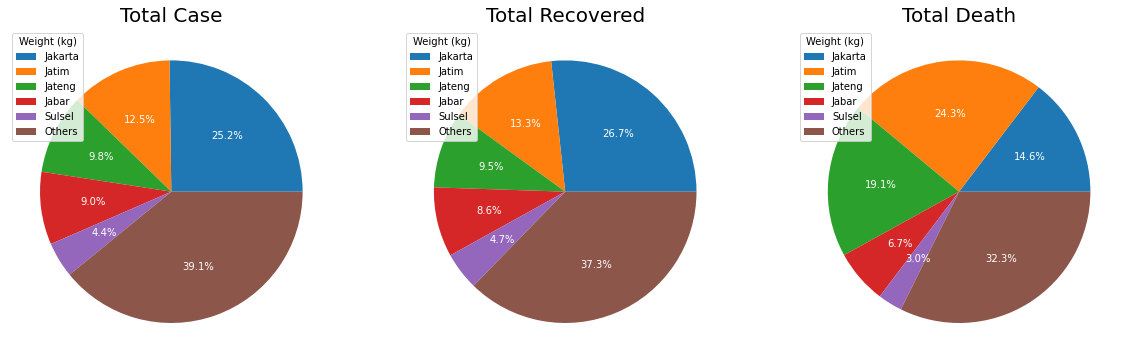

In [4]:
df_province_summary.sort_values(by='Covid19+ Total', ascending=False, inplace=True)

total_case = df_province_summary.iloc[:5,12]
total_case.loc['Others'] = df_province_summary.iloc[5:,12].sum()

total_recovered = df_province_summary.iloc[:5,14]
total_recovered.loc['Others'] = df_province_summary.iloc[5:,14].sum()

total_death = df_province_summary.iloc[:5,15]
total_death.loc['Others'] = df_province_summary.iloc[5:,15].sum()

# --------------------------- PLOT ---------------------------
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,10))
wedges, text, autotexts = ax1.pie(total_case, autopct='%1.1f%%', textprops={'color':"w"})
ax1.set_title('Total Case', fontsize = 20)
ax1.legend(wedges, total_case.index, title="Weight (kg)", loc="upper left", fontsize=10)

wedges, text, autotexts = ax2.pie(total_recovered, autopct='%1.1f%%', textprops={'color':"w"})
ax2.set_title('Total Recovered', fontsize = 20)
ax2.legend(wedges, total_recovered.index, title="Weight (kg)", loc="upper left", fontsize=10)

wedges, text, autotexts = ax3.pie(total_death, autopct='%1.1f%%', textprops={'color':"w"})
ax3.set_title('Total Death', fontsize = 20)
ax3.legend(wedges, total_death.index, title="Weight (kg)", loc="upper left", fontsize=10)

Next, let's see the distribution each category more spesifically.

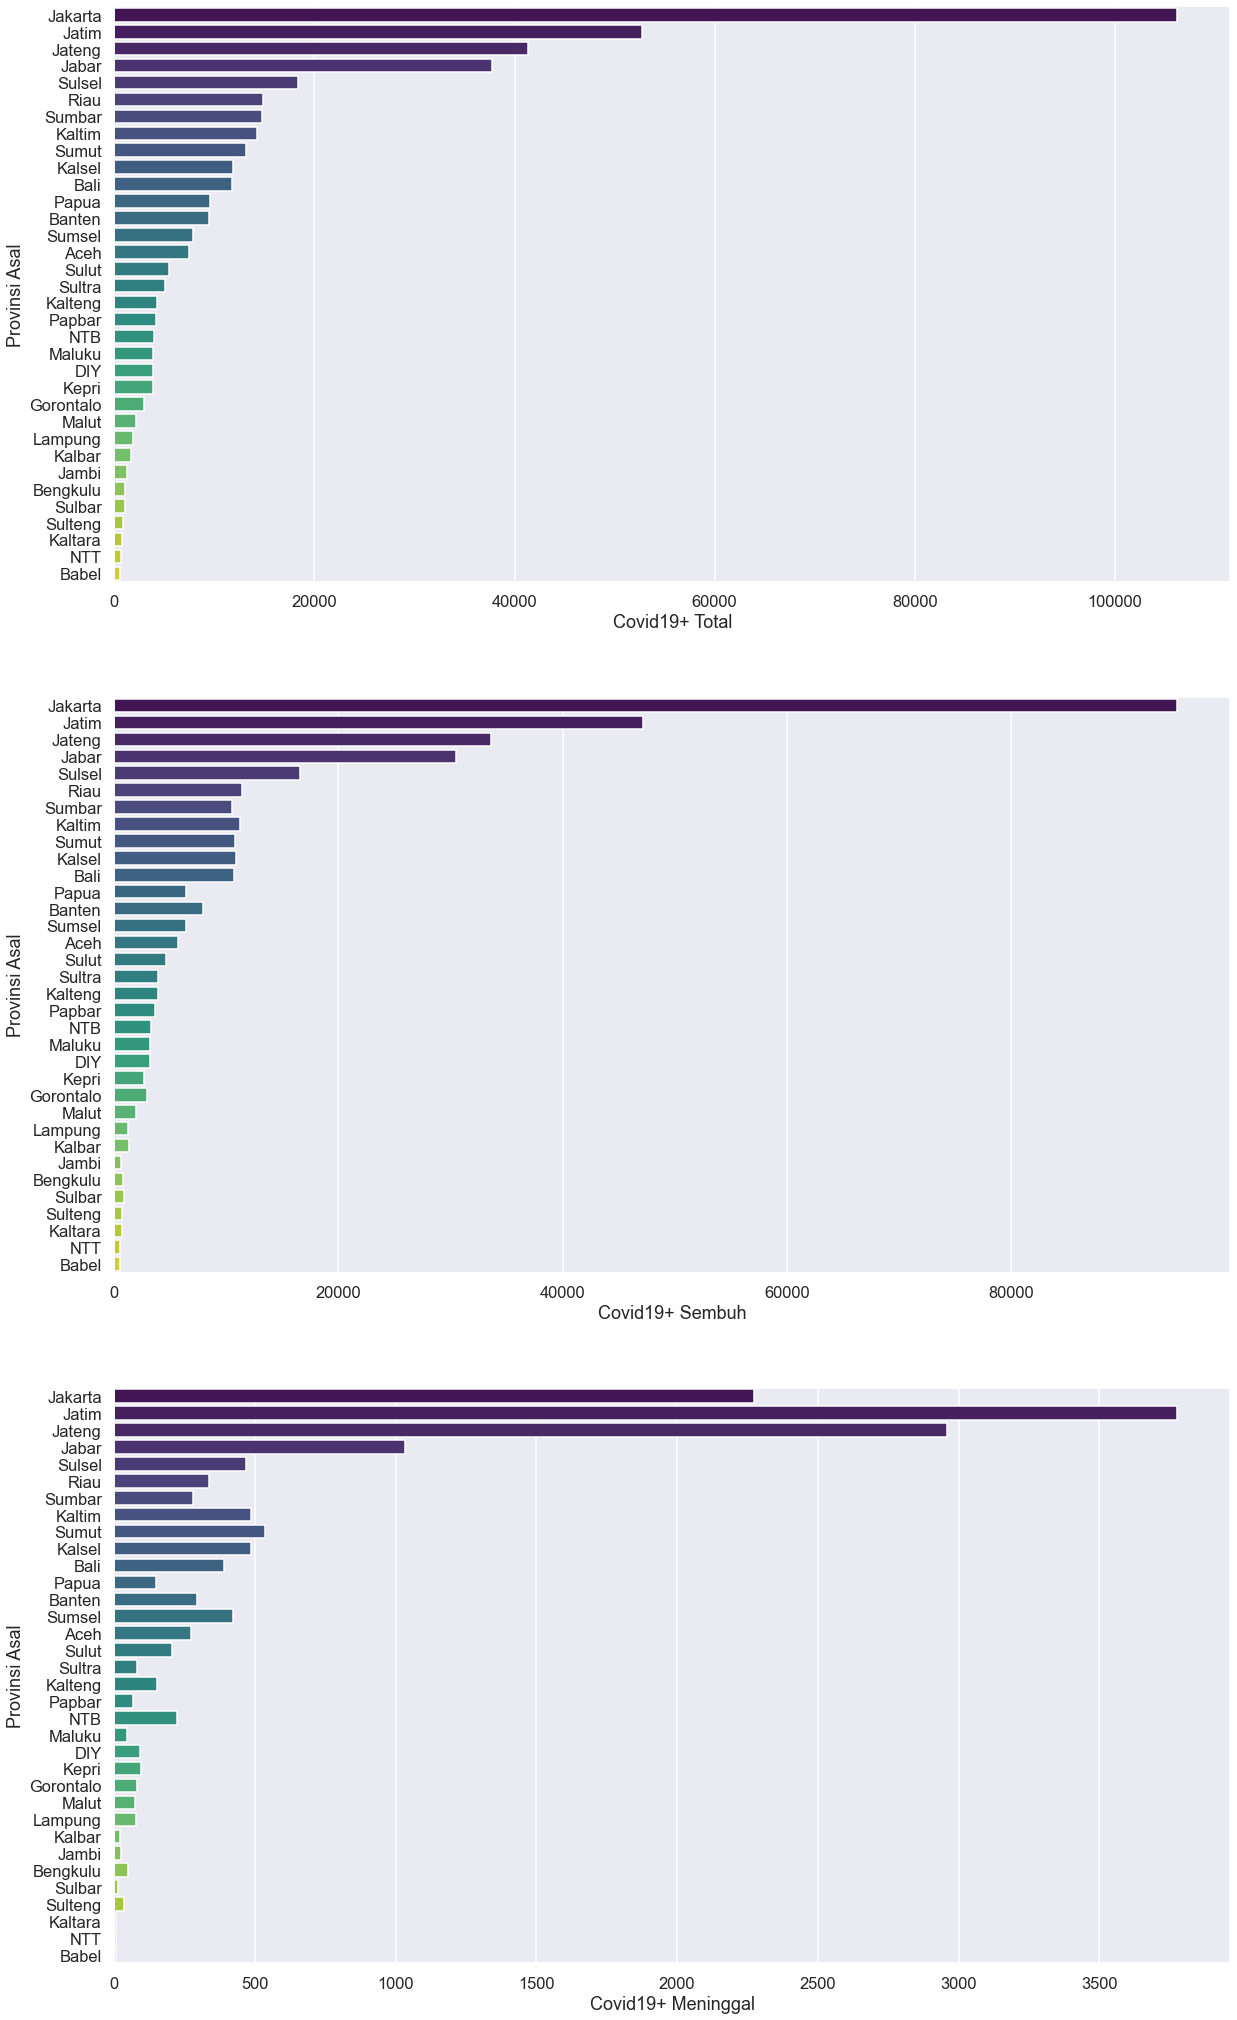

In [5]:
sns.set_context('talk')
sns.set_style('darkgrid')
fig, (ax1,ax2,ax3) = plt.subplots(ncols=1, nrows=3, figsize=(20,36))

sns.barplot(x='Covid19+ Total', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax1)
ax1.grid(b=True, which='minor', linestyle='--')

sns.barplot(x='Covid19+ Sembuh', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax2)
ax2.grid(b=True, which='minor', linestyle='--')

sns.barplot(x='Covid19+ Meninggal', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax3)
ax3.grid(b=True, which='minor', linestyle='--')

Now let's see the recovered and death ratio for each city. 
- Red vertical line is national recovered ratio and national death ratio

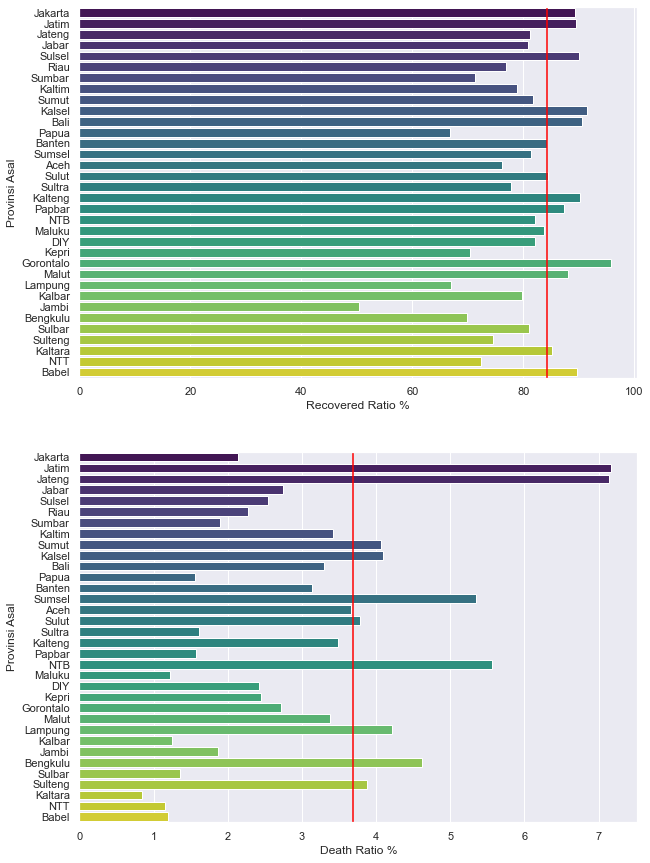

In [6]:
sns.set_context('notebook')
sns.set_style('darkgrid')

national_recovered_ratio = df_province_summary['Covid19+ Sembuh'].sum()*100/df_province_summary['Covid19+ Total'].sum()
national_death_ratio = df_province_summary['Covid19+ Meninggal'].sum()*100/df_province_summary['Covid19+ Total'].sum()

df_province_summary['Death Ratio %'] = df_province_summary['Covid19+ Meninggal']*100/df_province_summary['Covid19+ Total']
df_province_summary['Recovered Ratio %'] = df_province_summary['Covid19+ Sembuh']*100/df_province_summary['Covid19+ Total']

fig, (ax1,ax2) = plt.subplots(ncols = 1, nrows=2, figsize=(10, 15))
sns.barplot(x='Recovered Ratio %', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax1)
ax1.axvline(national_recovered_ratio, color='r', label='Nationa Average')

sns.barplot(x='Death Ratio %', y='Provinsi Asal', data=df_province_summary.reset_index(), palette='viridis', ax=ax2)
ax2.axvline(national_death_ratio, color='r', label='Nationa Average')

- It appears that java island is still the dominant area of virus spreadness. It is shown by 4 province with most cases are in java.
- Spesifically, one fourth of total case came from Jakarta. However, Jakarta seemed better in reducing death cases than East Java and West Java.

# *Timeline each province*
## Moving average 7 days

In [7]:
ma_daily_case = df_daily_case.T.copy()
temp = df_daily_case.T

for i in range(1,35):
    for j in range (6, ma_daily_case.shape[1]):
        ma_daily_case.iloc[i,j] = np.round((temp.iloc[i,j] + temp.iloc[i,j-1] + 
                                             temp.iloc[i,j-2] + temp.iloc[i,j-3] + 
                                             temp.iloc[i,j-4] + temp.iloc[i,j-5] + 
                                             temp.iloc[i,j-6])/7)

ma_daily_case.drop([0,1,2,3,4,5], axis=1, inplace=True)
# ma_daily_case = ma_daily_case.astype(dtype='int64')

ma_daily_case.head()

,6,7,8,9,10,11,12,13,14,15,...,222,223,224,225,226,227,228,229,230,231
Date,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,...,2020-10-23 00:00:00,2020-10-24 00:00:00,2020-10-25 00:00:00,2020-10-26 00:00:00,2020-10-27 00:00:00,2020-10-28 00:00:00,2020-10-29 00:00:00,2020-10-30 00:00:00,2020-10-31 00:00:00,2020-11-01 00:00:00
Aceh,0,0,0,0,0,0,1,1,1,1,...,112,98,94,84,71,71,61,51,40,31
Bali,0,0,1,1,1,1,1,1,1,2,...,85,83,88,82,81,78,75,73,69,62
Banten,4,4,5,7,6,5,6,7,7,9,...,142,139,153,153,159,159,141,135,132,112
Babel,0,0,0,0,0,0,0,0,0,0,...,8,7,5,5,6,5,5,5,5,5


In [8]:
def plot_timeline(x,y,province,color,alpha):
    ax[x,y].plot(ma_daily_case.loc[province,:], color=color)
    ax[x,y].fill_between(columns, 0, ma_daily_case.loc[province,:].astype('int32'), color=color, alpha=alpha)
    plt.text(text_x, text_y1, province, transform=ax[x,y].transAxes, fontsize=fontsize, color=color)
    plt.text(text_x, text_y2, df_daily_case.T.loc[province,:].sum(), transform=ax[x,y].transAxes, fontsize=fontsize, color=color)

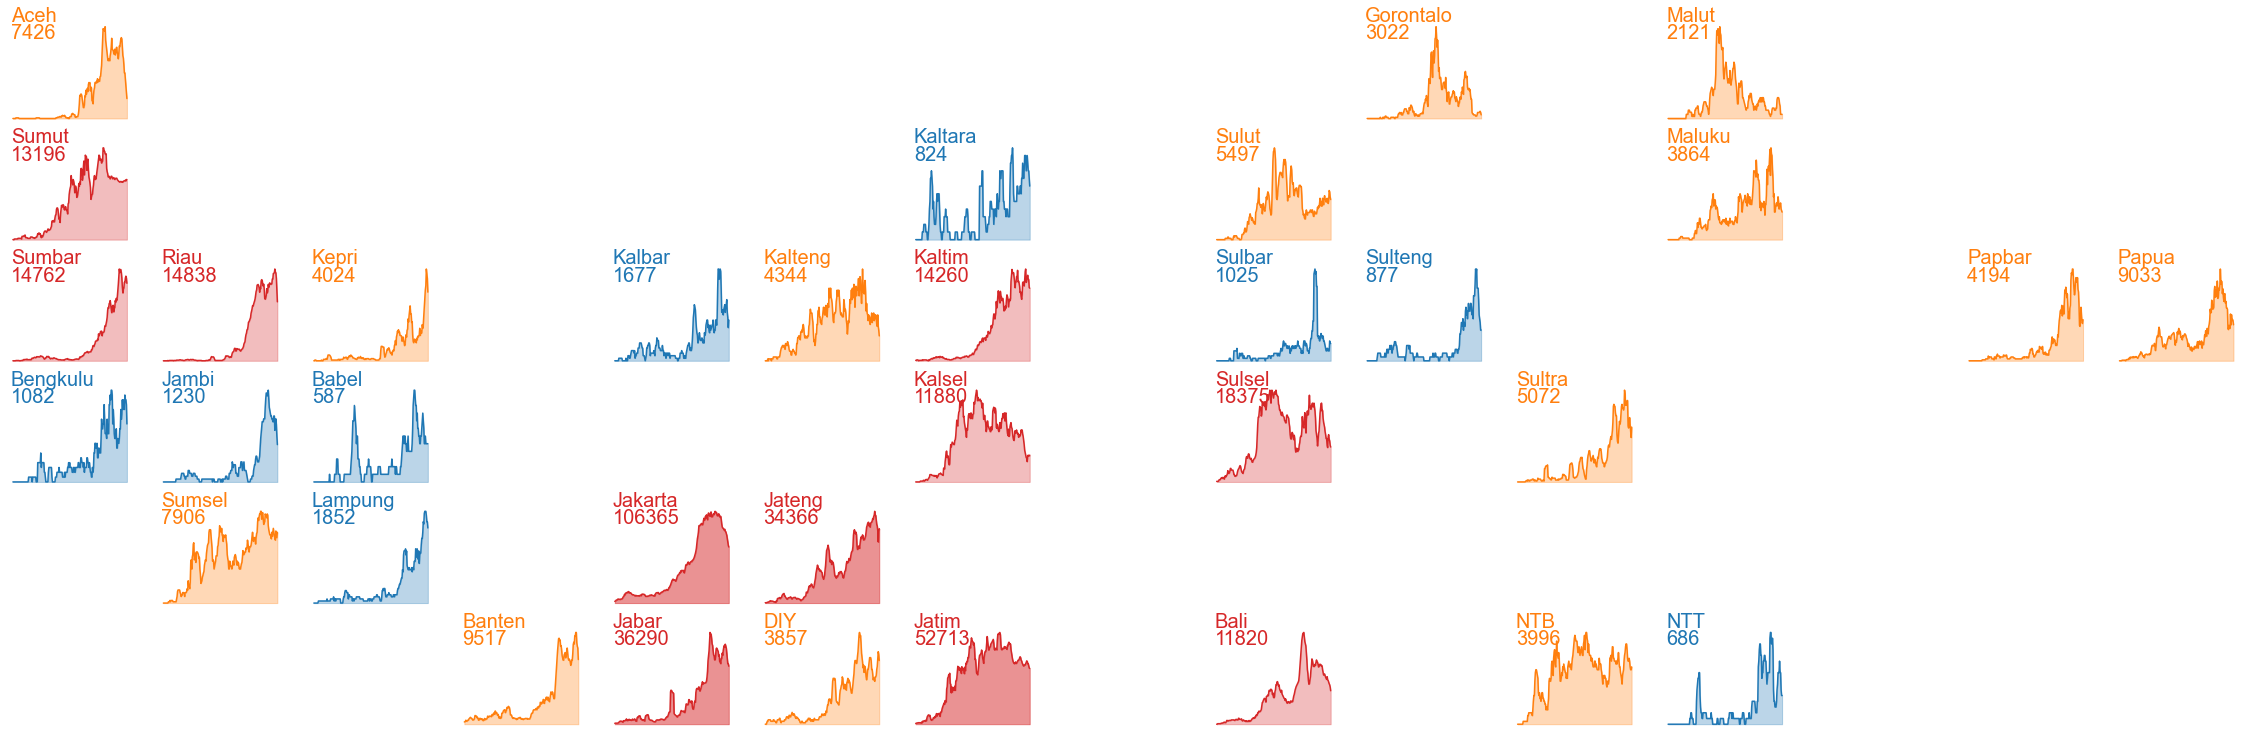

In [9]:
text_x = 0.03
text_y1 = 1
text_y2 = 0.83
fontsize = 20
columns = ma_daily_case.columns
ncols = 15
nrows = 6

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40,13))
# SUMATERA -----
plot_timeline(0,0,'Aceh','tab:orange',0.3)
plot_timeline(1,0,'Sumut','tab:red',0.3)
plot_timeline(2,0,'Sumbar','tab:red',0.3)
plot_timeline(3,0,'Bengkulu','tab:blue',0.3)
plot_timeline(2,1,'Riau','tab:red',0.3)
plot_timeline(3,1,'Jambi','tab:blue',0.3)
plot_timeline(4,1,'Sumsel','tab:orange',0.3)
plot_timeline(2,2,'Kepri','tab:orange',0.3)
plot_timeline(3,2,'Babel','tab:blue',0.3)
plot_timeline(4,2,'Lampung','tab:blue',0.3)

# JAWA -----
plot_timeline(5,3,'Banten','tab:orange',0.3)
plot_timeline(4,4,'Jakarta','tab:red',0.5)
plot_timeline(5,4,'Jabar','tab:red',0.5)
plot_timeline(4,5,'Jateng','tab:red',0.5)
plot_timeline(5,5,'DIY','tab:orange',0.3)
plot_timeline(5,6,'Jatim','tab:red',0.5)

# KALIMANTAN -----
plot_timeline(2,4,'Kalbar','tab:blue',0.3)
plot_timeline(2,5,'Kalteng','tab:orange',0.3)
plot_timeline(1,6,'Kaltara','tab:blue',0.3)
plot_timeline(2,6,'Kaltim','tab:red',0.3)
plot_timeline(3,6,'Kalsel','tab:red',0.3)

# SULAWESI -----
plot_timeline(0,9,'Gorontalo','tab:orange',0.3)
plot_timeline(1,8,'Sulut','tab:orange',0.3)
plot_timeline(2,8,'Sulbar','tab:blue',0.3)
plot_timeline(2,9,'Sulteng','tab:blue',0.3)
plot_timeline(3,8,'Sulsel','tab:red',0.3)
plot_timeline(3,10,'Sultra','tab:orange',0.3)

# GUGUS KEPULAUAN -----
plot_timeline(5,8,'Bali','tab:red',0.3)
plot_timeline(5,10,'NTB','tab:orange',0.3)
plot_timeline(5,11,'NTT','tab:blue',0.3)
plot_timeline(0,11,'Malut','tab:orange',0.3)
plot_timeline(1,11,'Maluku','tab:orange',0.3)

# PAPUA -----
plot_timeline(2,13,'Papbar','tab:orange',0.3)
plot_timeline(2,14,'Papua','tab:orange',0.3)

for i in range(nrows):
    for j in range(ncols):
        ax[i,j].axis('off')

# *Progress to Zero (P0)*
- p0 (Progress to Zero): https://www.medrxiv.org/content/10.1101/2020.05.21.20109298v1.full.pdf+html
- P0 = 1 - (last data/max)

In [10]:
p0 = pd.DataFrame(index=ma_daily_case.iloc[1:,:].index, columns=['p0'])
temp = ma_daily_case.iloc[1:,:]

for i in range(0,34):
    max = temp.iloc[i,:].max()
    p0.iloc[i,0] = 100 - round(temp.iloc[i,-1]*100/max)

p0 = p0.astype('int32')
p0.T

,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,Jateng,...,Sulteng,Lampung,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo
p0,78,64,30,58,37,31,39,59,37,19,...,67,18,36,95,70,55,61,81,69,96


## Visualize P0 to map

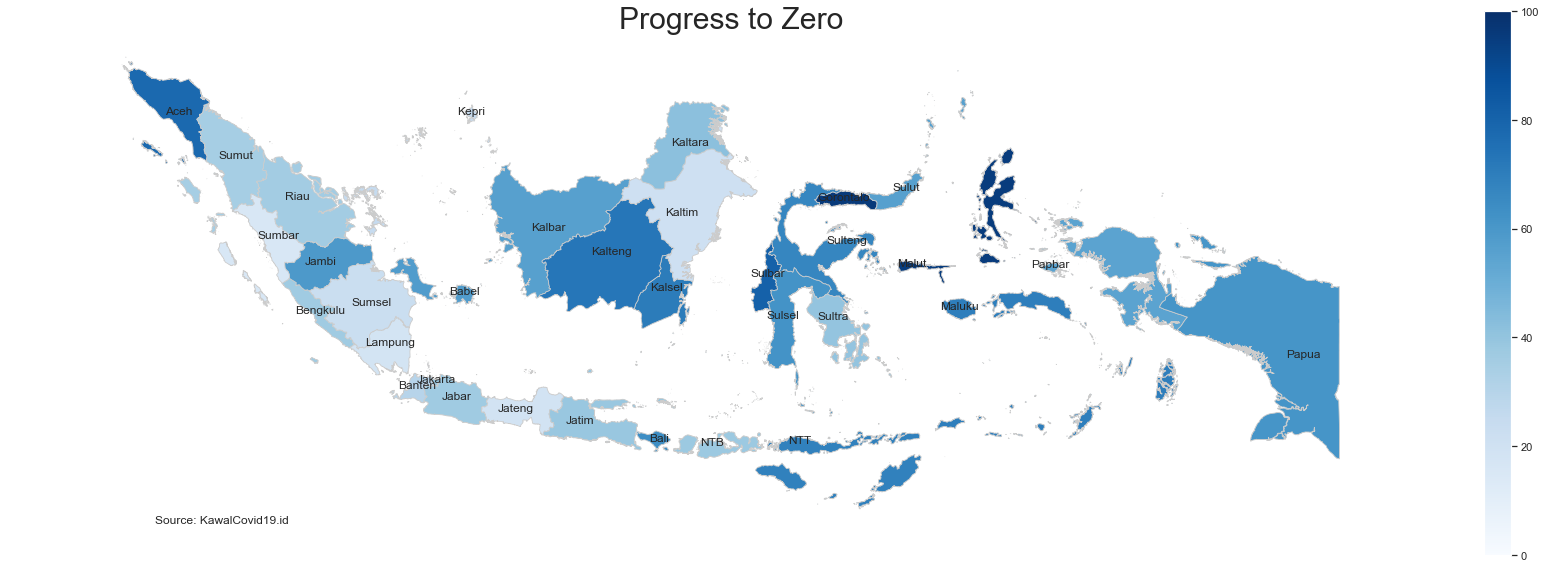

In [31]:
p0_geo = df_geo.join(p0, how='inner').reset_index()
p0_geo.rename(columns={'index':'province'}, inplace=True)

vmin, vmax = 0, 100


fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('Off')
ax.set_title('Progress to Zero', fontsize=30)
ax.annotate('Source: KawalCovid19.id', xy=(0.1, .1), xycoords='figure fraction')

sm = plt.cm.ScalarMappable(cmap='Blues', norm = plt.Normalize(vmin = vmin, vmax = vmax))
cbar = fig.colorbar(sm)
p0_geo.plot('p0', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', norm = plt.Normalize(vmin = vmin, vmax = vmax))


p0_geo['coords'] = p0_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
p0_geo['coords'] = [coords[0] for coords in p0_geo['coords']]
for idx, row in p0_geo.iterrows():
    plt.annotate(s=row['province'], xy=row['coords'], horizontalalignment='center')
# p0_geo

# *Rasio Lacak Isolasi (RLI)*
- RLI (Rasio Lacak Isolasi): https://kawalcovid19.id/content/1294/serial-data-virus-korona-2-rasio-lacak-isolasi-rli-dan-korelasinya-dengan-kematian-kumulatif
- RLI = (ODP Total + PDP + Suspect Total + Probable Total)/Covid19+ Total

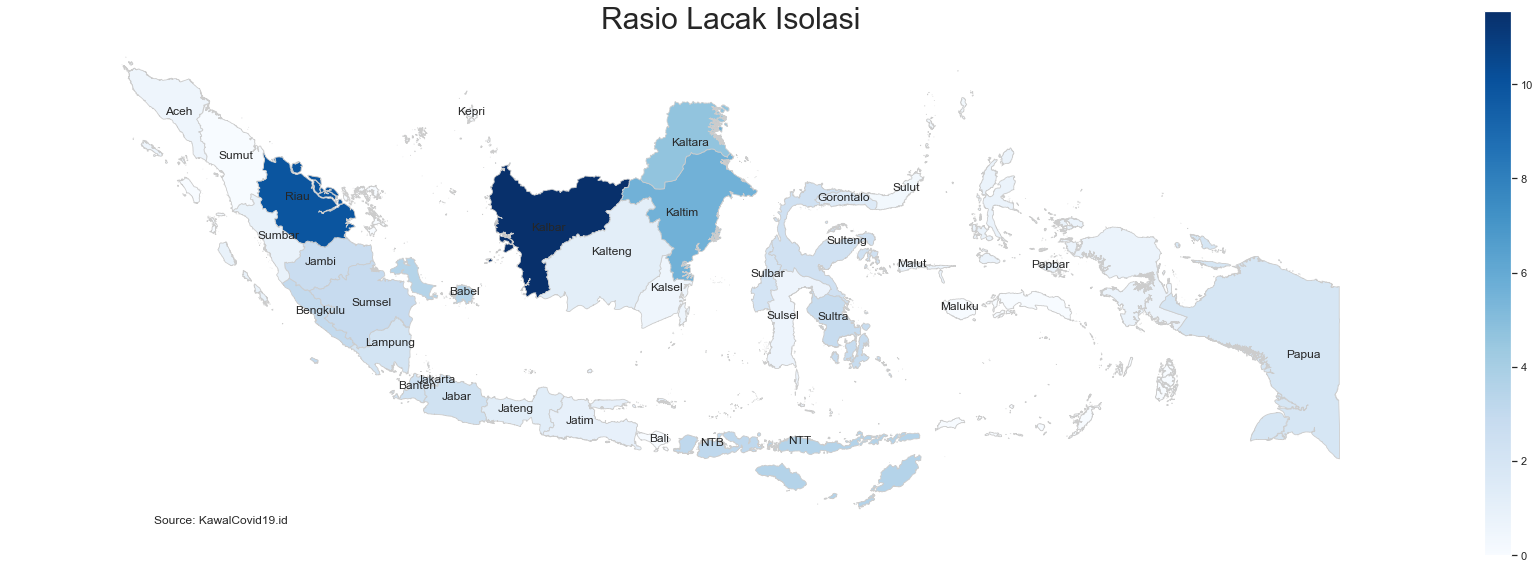

In [30]:
df_province_summary['RLI'] = (df_province_summary['ODP Total'] + df_province_summary['PDP'] + 
                              df_province_summary['Suspect Total'] + df_province_summary['Probable Total'])/df_province_summary['Covid19+ Total']
df_province_summary['RLI'] = df_province_summary['RLI'].astype('float32')

rli_geo = df_geo.join(df_province_summary, how='inner').reset_index()
rli_geo = rli_geo.iloc[:,[0,1,-1]]
rli_geo.rename(columns={'index':'province'}, inplace=True)


vmin, vmax = df_province_summary['RLI'].min(), df_province_summary['RLI'].max()


fig, ax = plt.subplots(1, figsize=(30,10))
ax.axis('Off')
ax.set_title('Rasio Lacak Isolasi', fontsize=30)
ax.annotate('Source: KawalCovid19.id', xy=(0.1, .1), xycoords='figure fraction')

sm = plt.cm.ScalarMappable(cmap='Blues', norm = plt.Normalize(vmin = vmin, vmax = vmax))
cbar = fig.colorbar(sm)
rli_geo.plot('RLI', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', norm = plt.Normalize(vmin = vmin, vmax = vmax))


rli_geo['coords'] = rli_geo['geometry'].apply(lambda x: x.representative_point().coords[:])
rli_geo['coords'] = [coords[0] for coords in rli_geo['coords']]
for idx, row in rli_geo.iterrows():
    plt.annotate(s=row['province'], xy=row['coords'], horizontalalignment='center')

# *R-naught (R0)*
- R0 (R-naught): https://www.nytimes.com/2020/04/23/world/europe/coronavirus-R0-explainer.html

In [34]:
0.2/0.05

4.0